In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from google.colab import files

In [3]:
# Load data
nba_clustered = pd.read_csv("NBA_Train_Clustered.csv")
ncaa_train = pd.read_csv("College2000_2020.csv")

print(f"✓ NBA data: {len(nba_clustered)} players")
print(f"✓ NCAA data: {len(ncaa_train)} players")

# Merge
merged_train = pd.merge(
    ncaa_train,
    nba_clustered[['PLAYER', 'Cluster', 'Cluster_Label']],
    left_on='Name',
    right_on='PLAYER',
    how='inner'
)

print(f"✓ Merged: {len(merged_train)} players")
print(f"\nCluster distribution:")
print(merged_train['Cluster_Label'].value_counts())

✓ NBA data: 1018 players
✓ NCAA data: 841 players
✓ Merged: 735 players

Cluster distribution:
Cluster_Label
Bust           225
Role Player    217
Bench          130
Superstar       98
Starter         65
Name: count, dtype: int64


In [6]:
# College features (same as previous models)
college_features = [
    'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
    'FT', 'FTA', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS'
]

# Check which features exist
available_features = [f for f in college_features if f in merged_train.columns]
print(f" Available features ({len(available_features)}): {available_features}")

# Create X and y
X = merged_train[available_features].copy()
y = merged_train['Cluster'].copy()

# Handle missing values
X = X.fillna(X.mean())

print(f"\n Feature matrix: {X.shape}")
print(f" Target distribution:")
print(y.value_counts().sort_index())

 Available features (17): ['G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']

 Feature matrix: (735, 17)
 Target distribution:
Cluster
0     98
1     65
2    217
3    130
4    225
Name: count, dtype: int64


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f" Training: {len(X_train)} samples")
print(f" Testing: {len(X_test)} samples")

# Scaling Random Forest for consistency from past modeling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(" Features scaled")

 Training: 588 samples
 Testing: 147 samples
 Features scaled


In [12]:
# Initialize Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,          # Number of trees
    max_depth=15,              # Max depth of trees
    min_samples_split=10,      # Min samples to split a node
    min_samples_leaf=4,        # Min samples at leaf node
    random_state=42,
    class_weight='balanced',   # Handle class imbalance
    n_jobs=-1,                 # Use all CPU cores
    verbose=0
)

# Train model
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = rf_model.predict(X_train_scaled)
y_test_pred = rf_model.predict(X_test_scaled)

# Calculate accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\n Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f" Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")


 Training Accuracy: 0.8878 (88.78%)
 Test Accuracy: 0.4626 (46.26%)


In [13]:
cluster_names = ['Superstar', 'All-Star', 'Role Player', 'Bench', 'Bust']

print(classification_report(y_test, y_test_pred,
                          target_names=cluster_names,
                          digits=3))

              precision    recall  f1-score   support

   Superstar      0.286     0.300     0.293        20
    All-Star      0.467     0.538     0.500        13
 Role Player      0.429     0.349     0.385        43
       Bench      0.571     0.769     0.656        26
        Bust      0.488     0.444     0.465        45

    accuracy                          0.463       147
   macro avg      0.448     0.480     0.460       147
weighted avg      0.456     0.463     0.455       147



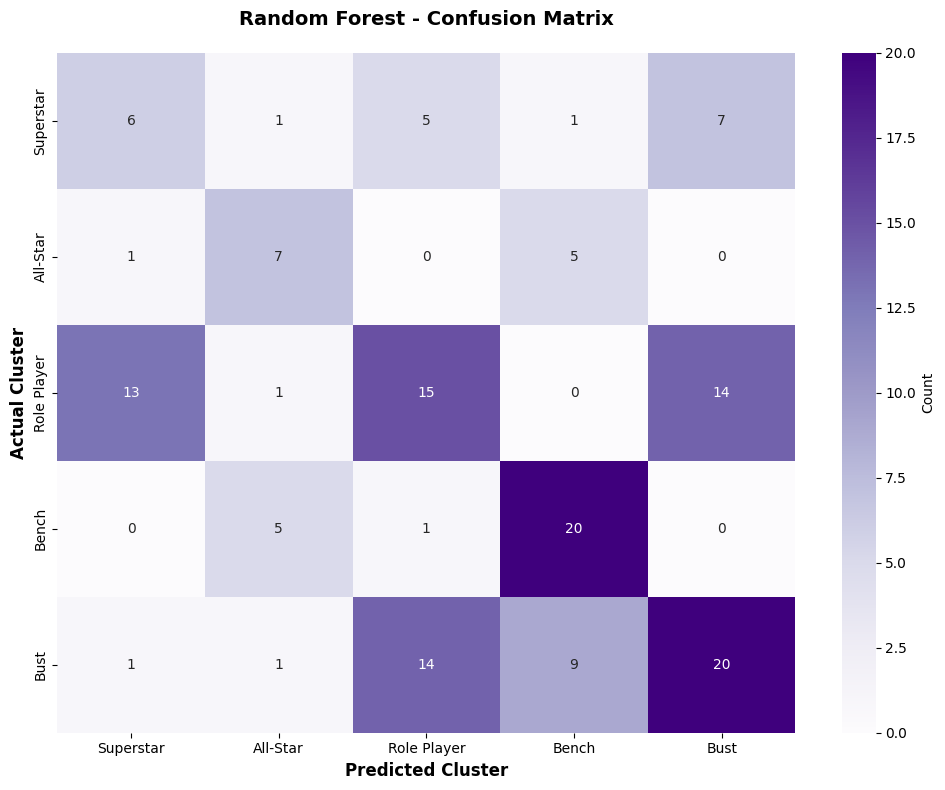


Confusion Matrix:
                    Pred Superstar  Pred All-Star  Pred Role Player  \
Actual Superstar                 6              1                 5   
Actual All-Star                  1              7                 0   
Actual Role Player              13              1                15   
Actual Bench                     0              5                 1   
Actual Bust                      1              1                14   

                    Pred Bench  Pred Bust  
Actual Superstar             1          7  
Actual All-Star              5          0  
Actual Role Player           0         14  
Actual Bench                20          0  
Actual Bust                  9         20  


In [15]:
cm = confusion_matrix(y_test, y_test_pred)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=cluster_names,
            yticklabels=cluster_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Cluster', fontsize=12, fontweight='bold')
plt.ylabel('Actual Cluster', fontsize=12, fontweight='bold')
plt.title('Random Forest - Confusion Matrix',
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nConfusion Matrix:")
cm_df = pd.DataFrame(cm,
                     index=[f"Actual {n}" for n in cluster_names],
                     columns=[f"Pred {n}" for n in cluster_names])
print(cm_df)


 Top 10 Most Important Features:
Feature  Importance
    3PA    0.099022
     3P    0.085889
    BLK    0.085815
    FG%    0.085536
    AST    0.076891
    TRB    0.071519
      G    0.067170
    STL    0.059624
    FT%    0.046519
    TOV    0.045949


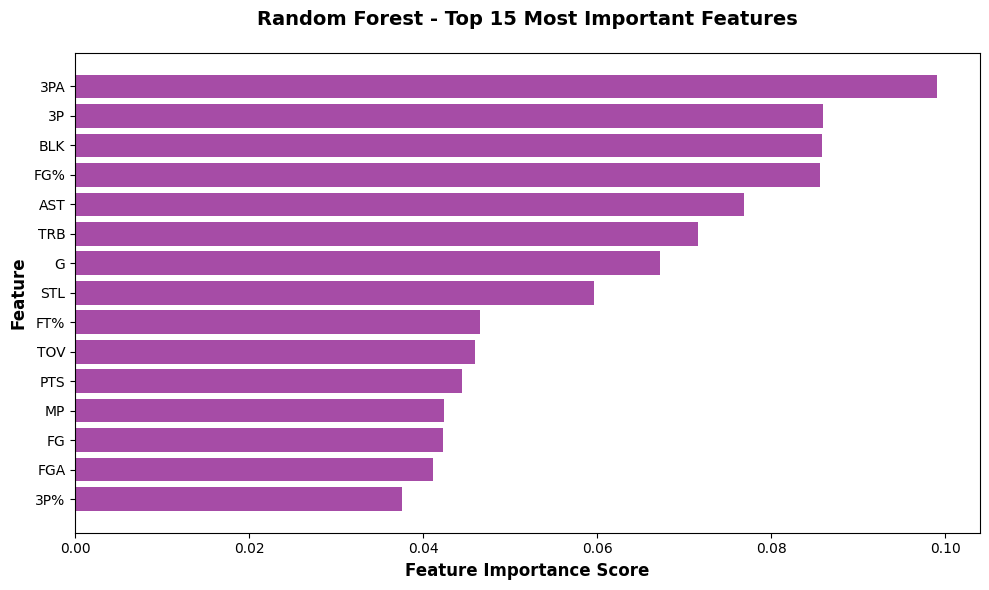

In [17]:
# Get feature importance from Random Forest
feature_importance = pd.DataFrame({
    'Feature': available_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Plot
plt.figure(figsize=(10, 6))
top_n = 15
top_features = feature_importance.head(top_n)

plt.barh(range(len(top_features)), top_features['Importance'], color='purple', alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance Score', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title(f'Random Forest - Top {top_n} Most Important Features',
          fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [19]:
# Load test data
nba_test_clustered = pd.read_csv("NBA_Test_Clustered.csv")
ncaa_test = pd.read_csv("NCAA_2020_2025.csv")

print(f" NBA test data: {len(nba_test_clustered)} players")
print(f" NCAA test data: {len(ncaa_test)} players")

# Merge test data
merged_test = pd.merge(
    ncaa_test,
    nba_test_clustered[['PLAYER', 'Cluster', 'Cluster_Label']],
    left_on='Name',
    right_on='PLAYER',
    how='inner'
)

print(f"✓ Merged test set: {len(merged_test)} players")
print(f"\nTest set cluster distribution:")
print(merged_test['Cluster_Label'].value_counts())

# Prepare test features
X_test_2020 = merged_test[available_features].copy()
y_test_2020 = merged_test['Cluster'].copy()
X_test_2020 = X_test_2020.fillna(X_test_2020.mean())
X_test_2020_scaled = scaler.transform(X_test_2020)

# Predict
y_pred_2020 = rf_model.predict(X_test_2020_scaled)
y_pred_2020_proba = rf_model.predict_proba(X_test_2020_scaled)

# Calculate accuracy
test_acc_2020 = accuracy_score(y_test_2020, y_pred_2020)

print(f"\n Random Forest Test Accuracy (2020-2025): {test_acc_2020:.4f} ({test_acc_2020*100:.2f}%)")

 NBA test data: 486 players
 NCAA test data: 109 players
✓ Merged test set: 91 players

Test set cluster distribution:
Cluster_Label
Bench               38
Role Player         27
Superstar           19
All-Star/Starter     5
Bust                 2
Name: count, dtype: int64

 Random Forest Test Accuracy (2020-2025): 0.3297 (32.97%)


In [20]:
print(classification_report(y_test_2020, y_pred_2020,
                          target_names=cluster_names,
                          digits=3))

              precision    recall  f1-score   support

   Superstar      0.667     0.526     0.588        19
    All-Star      0.444     0.800     0.571         5
 Role Player      0.452     0.519     0.483        27
       Bench      0.333     0.053     0.091        38
        Bust      0.000     0.000     0.000         2

    accuracy                          0.330        91
   macro avg      0.379     0.379     0.347        91
weighted avg      0.437     0.330     0.335        91



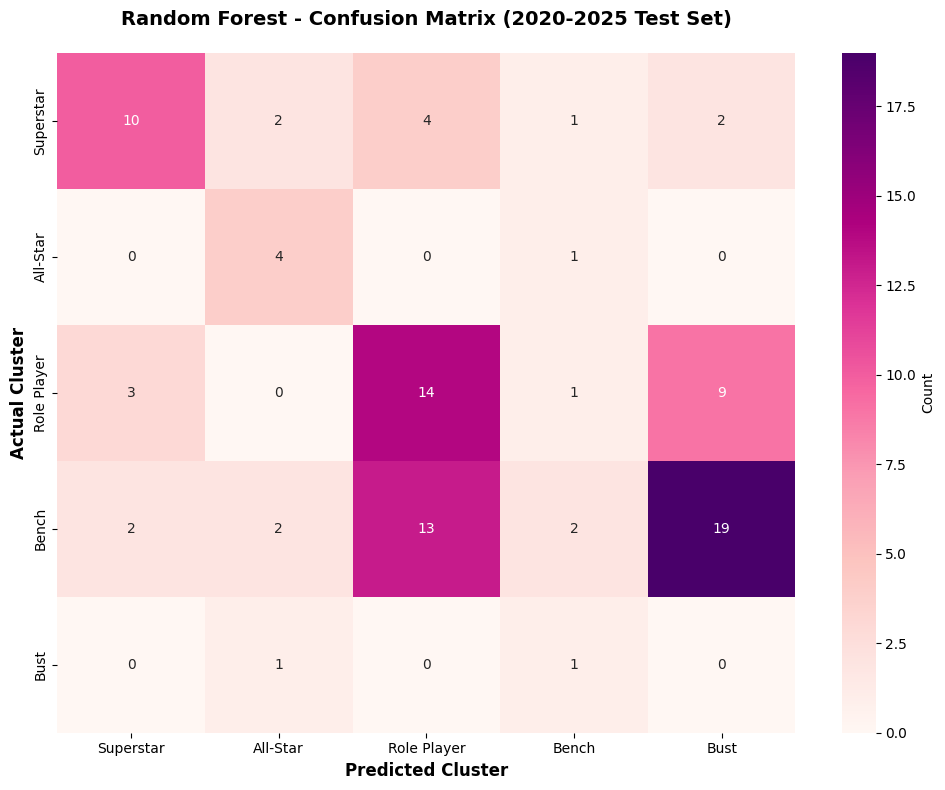

In [21]:
cm_2020 = confusion_matrix(y_test_2020, y_pred_2020)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm_2020, annot=True, fmt='d', cmap='RdPu',
            xticklabels=cluster_names,
            yticklabels=cluster_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Cluster', fontsize=12, fontweight='bold')
plt.ylabel('Actual Cluster', fontsize=12, fontweight='bold')
plt.title('Random Forest - Confusion Matrix (2020-2025 Test Set)',
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [24]:

merged_test['Predicted_Cluster'] = y_pred_2020
merged_test['Predicted_Label'] = [cluster_names[p] for p in y_pred_2020]
merged_test['Correct'] = merged_test['Cluster'] == merged_test['Predicted_Cluster']
merged_test['Confidence'] = y_pred_2020_proba.max(axis=1)

# Correct predictions
print("\n CORRECT PREDICTIONS:")
correct = merged_test[merged_test['Correct'] == True].sort_values('PTS', ascending=False)
print(correct[['Name', 'PTS', 'TRB', 'AST', 'Cluster_Label', 'Predicted_Label']].head(15).to_string(index=False))

# Incorrect predictions
print("\n INCORRECT PREDICTIONS:")
incorrect = merged_test[merged_test['Correct'] == False].sort_values('PTS', ascending=False)
print(incorrect[['Name', 'PTS', 'TRB', 'AST', 'Cluster_Label', 'Predicted_Label']].head(15).to_string(index=False))

# High-confidence predictions
print("\n HIGH-CONFIDENCE CORRECT PREDICTIONS (>80% confidence):")
high_conf = merged_test[(merged_test['Correct'] == True) & (merged_test['Confidence'] > 0.8)].sort_values('Confidence', ascending=False)
print(high_conf[['Name', 'PTS', 'Cluster_Label', 'Confidence']].head(10).to_string(index=False))


 CORRECT PREDICTIONS:
           Name  PTS  TRB  AST    Cluster_Label Predicted_Label
     Trae Young 27.4  3.9  8.7        Superstar       Superstar
   Kevin Durant 25.8 11.1  1.3        Superstar       Superstar
  Stephen Curry 25.3  4.5  3.7        Superstar       Superstar
 Markelle Fultz 23.2  5.7  5.9        Superstar       Superstar
  Deandre Ayton 20.1 11.6  1.6 All-Star/Starter        All-Star
Cade Cunningham 20.1  6.2  3.5        Superstar       Superstar
   James Harden 19.0  5.4  3.7        Superstar       Superstar
      Zach Edey 18.2  9.6  1.3 All-Star/Starter        All-Star
 Andrew Wiggins 17.1  5.9  1.5      Role Player     Role Player
    Ayo Dosunmu 16.7  4.8  3.9      Role Player     Role Player
   Marcus Smart 16.6  5.9  4.5        Superstar       Superstar
    Evan Mobley 16.4  8.7  2.4 All-Star/Starter        All-Star
  Keegan Murray 15.8  7.0  1.0      Role Player     Role Player
Kyle Filipowski 15.8  8.6  2.2      Role Player     Role Player
Lauri Markkanen 1

In [43]:

aging_vets = [
    'LeBron James', 'Kevin Durant', 'Stephen Curry', 'James Harden',
    'Russell Westbrook', 'Chris Paul', 'Carmelo Anthony', 'Klay Thompson',
    'Kawhi Leonard', 'Paul George', 'Jimmy Butler', 'Kyle Lowry',
    'DeMar DeRozan', 'Kevin Love', 'Blake Griffin', 'Al Horford',
    'Jeff Teague', 'George Hill', 'Marc Gasol', 'Dwight Howard', 'Jamal Murray', 'Georges Niang', 'Marcus Smart', 'Andrew Wiggins',
    'Buddy Hield', 'Trae Young', 'Malik Monk', 'Markelle Fultz', 'Jordan Clarkson', 'Seth Curry', 'Trey Burke', 'Delon Wright',
    'Julius Randle', 'Bobby Portis', 'Zion Williamson', 'Ben Simmons', 'Jalen Brunson', 'Lonzo Ball'
]

# Statistical exclusion (high college scorer + low NBA label = aging vet)
suspicious = merged_test[
    (merged_test['PTS'] >= 20) &
    (merged_test['Cluster_Label'].isin(['Role Player', 'Bench']))
]['Name'].tolist()

print(f"Manual exclusion list: {len(aging_vets)} players")
print(f"Statistical exclusion: {len(suspicious)} players")

# Combine lists
all_exclusions = list(set(aging_vets + suspicious))
print(f"Total exclusions: {len(all_exclusions)} unique players")

# Filter
merged_test_young = merged_test[~merged_test['Name'].isin(all_exclusions)].copy()

print(f"\n Results:")
print(f"Original test set: {len(merged_test)} players")
print(f"Young players set: {len(merged_test_young)} players")
print(f"Removed: {len(merged_test) - len(merged_test_young)} players")

excluded = merged_test[merged_test['Name'].isin(all_exclusions)]
if len(excluded) > 0:
    print(f"\n Excluded players:")
    print(excluded[['Name', 'PTS', 'Cluster_Label']].sort_values('PTS', ascending=False).to_string(index=False))

# Show young players distribution
print(f"\n Young players cluster distribution:")
print(merged_test_young['Cluster_Label'].value_counts())

# Show sample of remaining players
print(f"\n Sample of young players:")
print(merged_test_young[['Name', 'PTS', 'TRB', 'AST', 'Cluster_Label']].sort_values('PTS', ascending=False).head(20).to_string(index=False))

Manual exclusion list: 38 players
Statistical exclusion: 1 players
Total exclusions: 38 unique players

 Results:
Original test set: 91 players
Young players set: 65 players
Removed: 26 players

 Excluded players:
           Name  PTS Cluster_Label
     Trae Young 27.4     Superstar
   Kevin Durant 25.8     Superstar
  Stephen Curry 25.3     Superstar
 Markelle Fultz 23.2     Superstar
Zion Williamson 22.6     Superstar
Carmelo Anthony 22.2   Role Player
   Jamal Murray 20.0     Superstar
     Malik Monk 19.8   Role Player
    Ben Simmons 19.2     Superstar
   James Harden 19.0     Superstar
     Kevin Love 17.5         Bench
    Buddy Hield 17.4   Role Player
 Andrew Wiggins 17.1   Role Player
     Trey Burke 16.9         Bench
   Marcus Smart 16.6     Superstar
    Jeff Teague 16.4         Bench
  Georges Niang 16.1         Bench
Jordan Clarkson 15.4   Role Player
   Bobby Portis 15.0   Role Player
   Delon Wright 15.0   Role Player
     Chris Paul 15.0     Superstar
  Julius Randle 